# XGBoost to predict discharge disability: SHAP

Using 7 features (as informed by the feature selection), using the multiclass classification model (as trained in notebook 040) to give the probability (likelihood) that each patient is in each discharge disability class (mRS 0, 1, 2, 3, 4, 5 or 6)

Using just the first kfold for validation (seen in notebooks 011 and 041 that the performance and patterns are consistent across the data divisions).

Examine the patterns that the model identifies in terms of feature importance and SHAP.

### Plain English summary

Let's look at the patterns detected by a model trained on the 7 features as infomred by feature selection, using the first k-fold split.

7 features:
1. prior_disability
1. stroke_severity
1. stroke_team
1. age
1. onset_to_thrombolysis_time
1. any_afib_diagnosis
1. precise_onset_known

### Model and data
Model: XGBoost classifier (multiclass classification) [from notebook 040]\
Target feature: Discharge disability\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)\
Kfold split: First kfold split

### Aims
What are the patterns that the model detects?

### Observations
Feature importance (as calcualted by XGBoost) is only returned for the model (as a whole) and not per output category.
The one hot encoded stroke team features dominate the list of 25 most importance features (22 of the top 25 are stroke teams). Here are the important features (omitting the one hot encoded stroke teams):
prior_disability, stroke_severity, nihss_arrival_loc, age, thrombolysis_no_but_improving, nihss_arrival_best_gaze, any_afib_diagnosis, scan_to_thrombolysis_time, year, nihss_arrival_motor_arm_left

#### Further work
Look at the difference of the SHAP for a single patient.

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea

https://github.com/Iditc/Posts-on-Medium/blob/main/Explainable%20AI/Explainable%20AI%20(XAI)%20with%20SHAP_MultiClass%20Classification%20Problem.ipynb

https://github.com/slundberg/shap/issues/367

(code orignially from 01a_xgb_kfold_all_features_accuracy_importance_shap.ipynb and 01_xgb_5fold_all_features_accuracy_importance_shap.ipynb)

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from dataclasses import dataclass

import pickle
import shap

from os.path import exists

import time
import datetime

Report the time duration to run notebook

In [2]:
start_time = time.time()

Choose number of kfolds (either =1 for the first kfold, or =5 for the full 5 kfold split)

In [3]:
k = 0

Select the features for the model

In [4]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", "age", 
                     "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features = len(selected_features)
selected_features.append('discharge_disability')

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [5]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_7_features_1fold'
    notebook: str = '051_'

paths = Paths()

Create output folders if needed

In [6]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

Import data and select the features for this model.

In [7]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, 
                        ('03_train_' + str(k) + '.csv'))
train = pd.read_csv(filename)
train = train[selected_features]

filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test = pd.read_csv(filename)
test = test[selected_features]

Store the output classes

In [8]:
class_names = train['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

Take copy of stroke team to use to create a histogram (before this feature is converted into a one hot encoded feature)

In [9]:
test_stroke_team = test["stroke_team"]

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [10]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [11]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [12]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        train = convert_feature_to_one_hot(train, feature, prefix)
        test = convert_feature_to_one_hot(test, feature, prefix)

Feature names with one hot encoding

In [13]:
features_ohe = list(train)
features_ohe.remove("discharge_disability")
n_features = len(features_ohe)

In [14]:
print(f"There are {len(selected_features)} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features} features (after one-hot encoding)")

There are 8 original features (before one-hot encoding)
There are 124 features (after one-hot encoding)


## Load XGBoost model

Load the model from notebook 040 that was trained on all features.

Create function to return X and y data for train and test sets

In [15]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    Args:
        train [dataframe]: dataframe containing training instances 
        test [dataframe]: dataframe containing test instances
        target [string]: column name of the targert feature (the column to 
                         separate from the two dataframes)

    Return:
        X_train [dataframe]: dataframe containing input features for the 
                            training instances 
        X_test [dataframe]: dataframe containing input features for the test
                            instances 
        y_train [dataframe]: dataframe containing target feature for the 
                            training instances 
        y_test [dataframe]: dataframe containing target feature for the test
                            instances 
    """    

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Create function to get xgboost model (print error if does not exist)

In [16]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else return that user needs to run notebook 040 to create the model.

    Arg:
        filename [string]: where xgboost model is saved

    Return:
        model [model object]: xgboost classification model 
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 040 first to train the model")
    return(model)

Create function to return SHAP values extension X and y data for train and test sets

In [17]:
def load_shap_extended(filename):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    model (xgboost object):
    k: kfold number
    X_train: training set (used as background data)
    X_test: test set (to calculate the SHAP values for)

    return the extended shap values (contains .values, .base, and .data)
        
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 041 first to train the model and calculate the SHAP"
              " values")
        
    return(shap_values_extended)

In [18]:
# Get k fold split
(X_train, X_test, y_train, y_test) = get_x_y_data(train,
                                                  test,
                                                 'discharge_disability')

# Model filename
filename = os.path.join(paths.model_save_path, 
                ('040_xgb_7_features_5fold_0.p'))

model = load_xgboost_model(filename)

# Get target categories from model
classes = model.classes_

# Get and store predicted probabilities
y_probs = model.predict_proba(X_test)

# Get and store predicted class
y_pred = model.predict(X_test)

# Calculate ROC AUC for multiclass models, using One vs Rest
roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                            multi_class = 'ovr', average = 'macro')

# Calculate error
y_error = y_test - y_pred
accuracy = np.mean(y_error==0)

error_within_one = np.mean(np.abs(y_error)<=1)

# Load feature importances (this dataframe contains all 5 kfolds)
filename = os.path.join(paths.data_save_path, 
                        ('041_xgb_7_features_5fold_feature_importance.csv'))
df_feature_importance = pd.read_csv(filename)
# Extract just the first kfold value
df_feature_importance = df_feature_importance['0']

# Load SHAP values for first kfold
# Set SHAP values filename
filename = os.path.join(paths.data_save_path, 
                        ('041_xgb_7_features_5fold_shap_values_extended_0.p'))

shap_values_extended = load_shap_extended(filename)
shap_values = shap_values_extended.values

print (f'7 features, accuracy: {accuracy:0.3f}')

print (f'7 features, accuracy within one: {error_within_one:0.3f}')

7 features, accuracy: 0.428
7 features, accuracy within one: 0.747


In [36]:
# Load feature importances (this dataframe contains all 5 kfolds)
filename = os.path.join(paths.data_save_path, 
                        ('041_xgb_7_features_5fold_feature_importance.csv'))
df_feature_importance = pd.read_csv(filename)
# Set column with stroke team name as index
df_feature_importance.rename(columns={"Unnamed: 0":"feature"}, inplace=True)
df_feature_importance.set_index("feature", inplace=True)

# Extract just the first kfold value
df_feature_importance = df_feature_importance['0']
df_feature_importance

feature
team_Royal Stoke University Hospital               0.047376
prior_disability                                   0.033415
team_Salford Royal Hospital                        0.029576
team_University Hospital of North Durham           0.025092
team_Sandwell District Hospital                    0.018564
                                                     ...   
team_Weston General Hospital                       0.002691
team_Dorset County Hospital                        0.002558
precise_onset_known                                0.002339
any_afib_diagnosis                                 0.002224
team_University Hospitals Dorset Stroke Service    0.001979
Name: 0, Length: 124, dtype: float64

## Section 1: Feature contribution

### Section 1.1: Feature Importances

https://stackoverflow.com/questions/58603632/how-to-get-feature-importance-for-each-class-in-mutliclass-classification-with-x)

The XGBoost algorithm provides a metrc per feature called "feature importance". It does not provide this value with respect ot the output class, just a single value for the whole model. We can analyse the feature importance values in the same way as if it is a binary classification model.

Examine the consitency of feature importances across k-fold splits.

A model is fitted to each k-fold split, and feature importance values are obtained for each model (but not for each output class). 

This next section assesses the range of feature importance values for each feature across the k-fold splits.

Create (and show) a dataframe that stores the min, median, and max feature importance value for each feature across the 5 k-fold splits

In [37]:
# Sort by importance (weight)
df_feature_importance = df_feature_importance.sort_values(ascending=False)

# Display top 15
df_feature_importance.head(15)

feature
team_Royal Stoke University Hospital        0.047376
prior_disability                            0.033415
team_Salford Royal Hospital                 0.029576
team_University Hospital of North Durham    0.025092
team_Leicester Royal Infirmary              0.019328
team_Sandwell District Hospital             0.018564
team_Royal Hallamshire Hospital             0.017819
team_Ysbyty Gwynedd                         0.017046
team_Pinderfields Hospital                  0.016385
team_Blackpool Victoria Hospital            0.015405
team_Derriford Hospital                     0.015163
team_Queen Alexandra Hospital Portsmouth    0.014944
team_Fairfield General Hospital             0.013976
team_East Surrey Hospital                   0.013974
stroke_severity                             0.013771
Name: 0, dtype: float64

Graph of % stroke team for the top n features

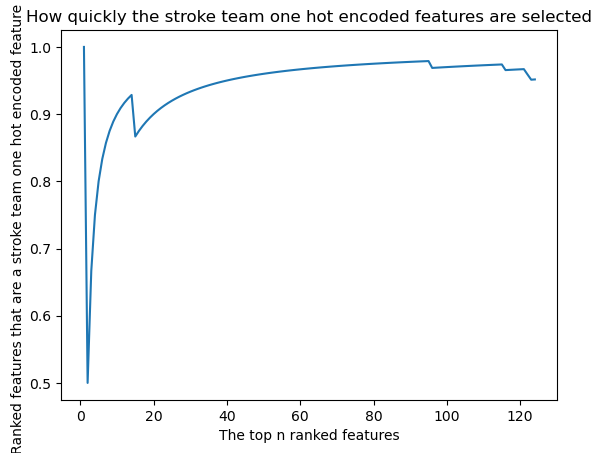

In [38]:
# Create a mask for feature names that don't contain string "team"
mask_exclude_team = ['team' not in i for i in list(df_feature_importance.index)]
mask_team = ['team' in i for i in list(df_feature_importance.index)]

list_pc_team_feature = [sum(mask_team[:i+1])/(i+1) for i in range(n_features)]

plt.plot(list(range(1, (n_features + 1),1)), list_pc_team_feature)
plt.title('How quickly the stroke team one hot encoded features are selected')
plt.xlabel('The top n ranked features')
plt.ylabel('Ranked features that are a stroke team one hot encoded feature (%)')

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_percent_team_ohe_features_ranked_importance.jpg'))
plt.savefig(filename, dpi=300)

Now show the top 15 features (in terms of importance), excluding the one hot encoded stroke team features

In [39]:
# Use a mask for feature names that don't contain string "team"
df_feature_importance[mask_exclude_team].head(15)

feature
prior_disability              0.033415
stroke_severity               0.013771
age                           0.004442
onset_to_thrombolysis_time    0.003058
precise_onset_known           0.002339
any_afib_diagnosis            0.002224
Name: 0, dtype: float64

Create a violin plot for the top 25 features with the highest feature importance values.

Shows the distribution of the feature importance values for each feature across the 5 kfold splits (the shaded area show the density of the data points).

The same data in each plot, the right one excludes the stroke team one hot encoded features.

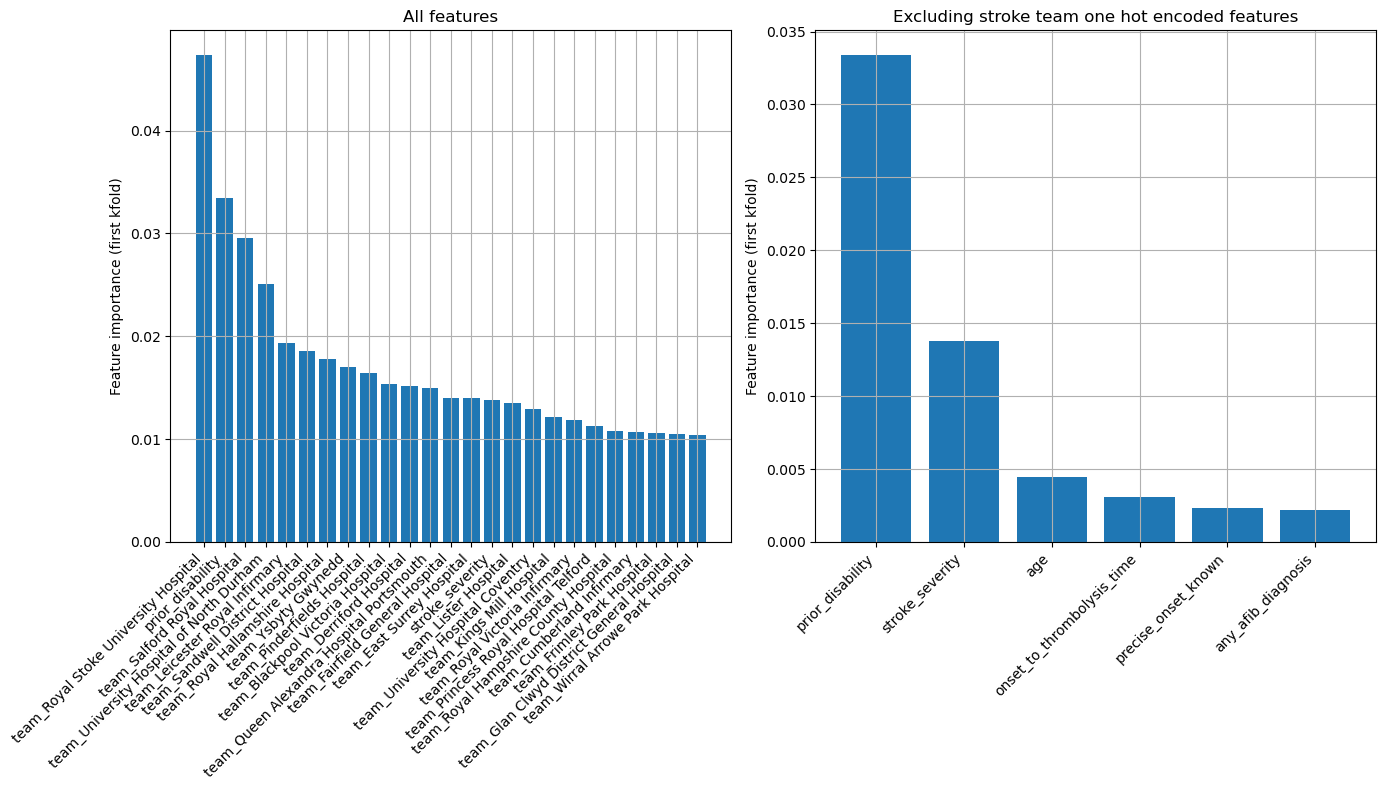

In [48]:
# Number of ranked features to show in plot
n_features_show = 25

# Set plot width based on number of features to show
width = 14 * (n_features_show/25)

# Set up figure
fig = plt.figure(figsize=(width,8))

# Set up first mask to include all features, and second mask to exclude stroke team
list_mask = [[True] * n_features, mask_exclude_team]
list_title = ['All features', 'Excluding stroke team one hot encoded features']

for subplot in range(2):
    features_show = (list(df_feature_importance[list_mask[subplot]].head(n_features_show).index))

    ax1 = fig.add_subplot(1,2,subplot+1)

    ax1.bar(features_show,
            df_feature_importance.loc[features_show].T)
    ax1.set_ylim(0)
    ax1.set_xticks(np.arange(0, len(features_show)))
    ax1.set_xticklabels(features_show, rotation=45, ha='right')
    ax1.grid(which='both')
    ax1.set_ylabel('Feature importance (first kfold)')
    ax1.set_title(list_title[subplot])

plt.tight_layout()

filename = (
    os.path.join(paths.image_save_path, 
                 (paths.notebook + paths.model_text + 
                  '_importance_violin.jpg')))

plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


## Section 1.2: SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance, for each of the 7 output classes. We can analyse the SHAP values in a different way than if it was a binary model.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

#### Get average SHAP values for this k-fold

Calculate the mean SHAP value for each feature (across all instances), for each of the 7 disability discharge output values. 

The mean is calculated in three ways:

1. mean of raw values
2. mean of absolute values
3. absolute of mean of raw values

In a separate dataframe (df_mean_abs_shap), store the mean of the absolute SHAP values for this kfold (a row per feature). A dataframe per output class.

In [42]:
# Initialise dictionary. Key name is output_class. Holds a list for dataframes
# for that class (for each kfold). The dataframe has a row per feature and a 
# column for the average SHAP values across all of the instances
dict_mean_abs_shap = {}

# For each output class
for c in range(n_classes):

    # Initialise DataFrame (stores mean of the absolute SHAP values for each kfold)
    df_mean_abs_shap = pd.DataFrame()

    # Calculate mean SHAP value for each feature (across all instances), for
    # this class
    shap_values_class = shap_values[:,:,c]
    df_shap_values_mean = pd.DataFrame(index=features_ohe)
    df_shap_values_mean['mean_shap'] = np.mean(shap_values_class, axis=0)
    df_shap_values_mean['abs_mean_shap'] = np.abs(df_shap_values_mean['mean_shap'])
    df_shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values_class), axis=0)
    df_shap_values_mean['rank'] = df_shap_values_mean['mean_abs_shap'].rank(ascending=False).values
    df_shap_values_mean.sort_index()
    
    # Store the mean of the absolute SHAP values in a dataframe 
    # The 3 columns (min, median, max) that were in df_mean_abs_shap_summary are now in df_mean_abs_shap
    # Store the dataframe for this class (row per feature, column per kfold (and summary statistics) for SHAPs across all instances)
    dict_mean_abs_shap[f'class{c}'] = df_shap_values_mean['mean_abs_shap']

In [44]:
df_mean_abs_shap

prior_disability                 1.054294
stroke_severity                  0.570699
age                              0.218952
onset_to_thrombolysis_time       0.132096
any_afib_diagnosis               0.015472
                                   ...   
team_Worthing Hospital           0.001207
team_Wycombe General Hospital    0.000000
team_Yeovil District Hospital    0.016061
team_York Hospital               0.000681
team_Ysbyty Gwynedd              0.004878
Name: mean_abs_shap, Length: 124, dtype: float64

For each output class, identify the 15 features with the highest SHAP values (in terms of the median of the kfolds of the mean of the absolute SHAP values) and create a violin plot.

Violin plots show the distribution of the shap values for each feature across the 5 kfold splits (the shaded area show the density of the data points).

The same data in each plot, the right one excludes the stroke team one hot encoded features.

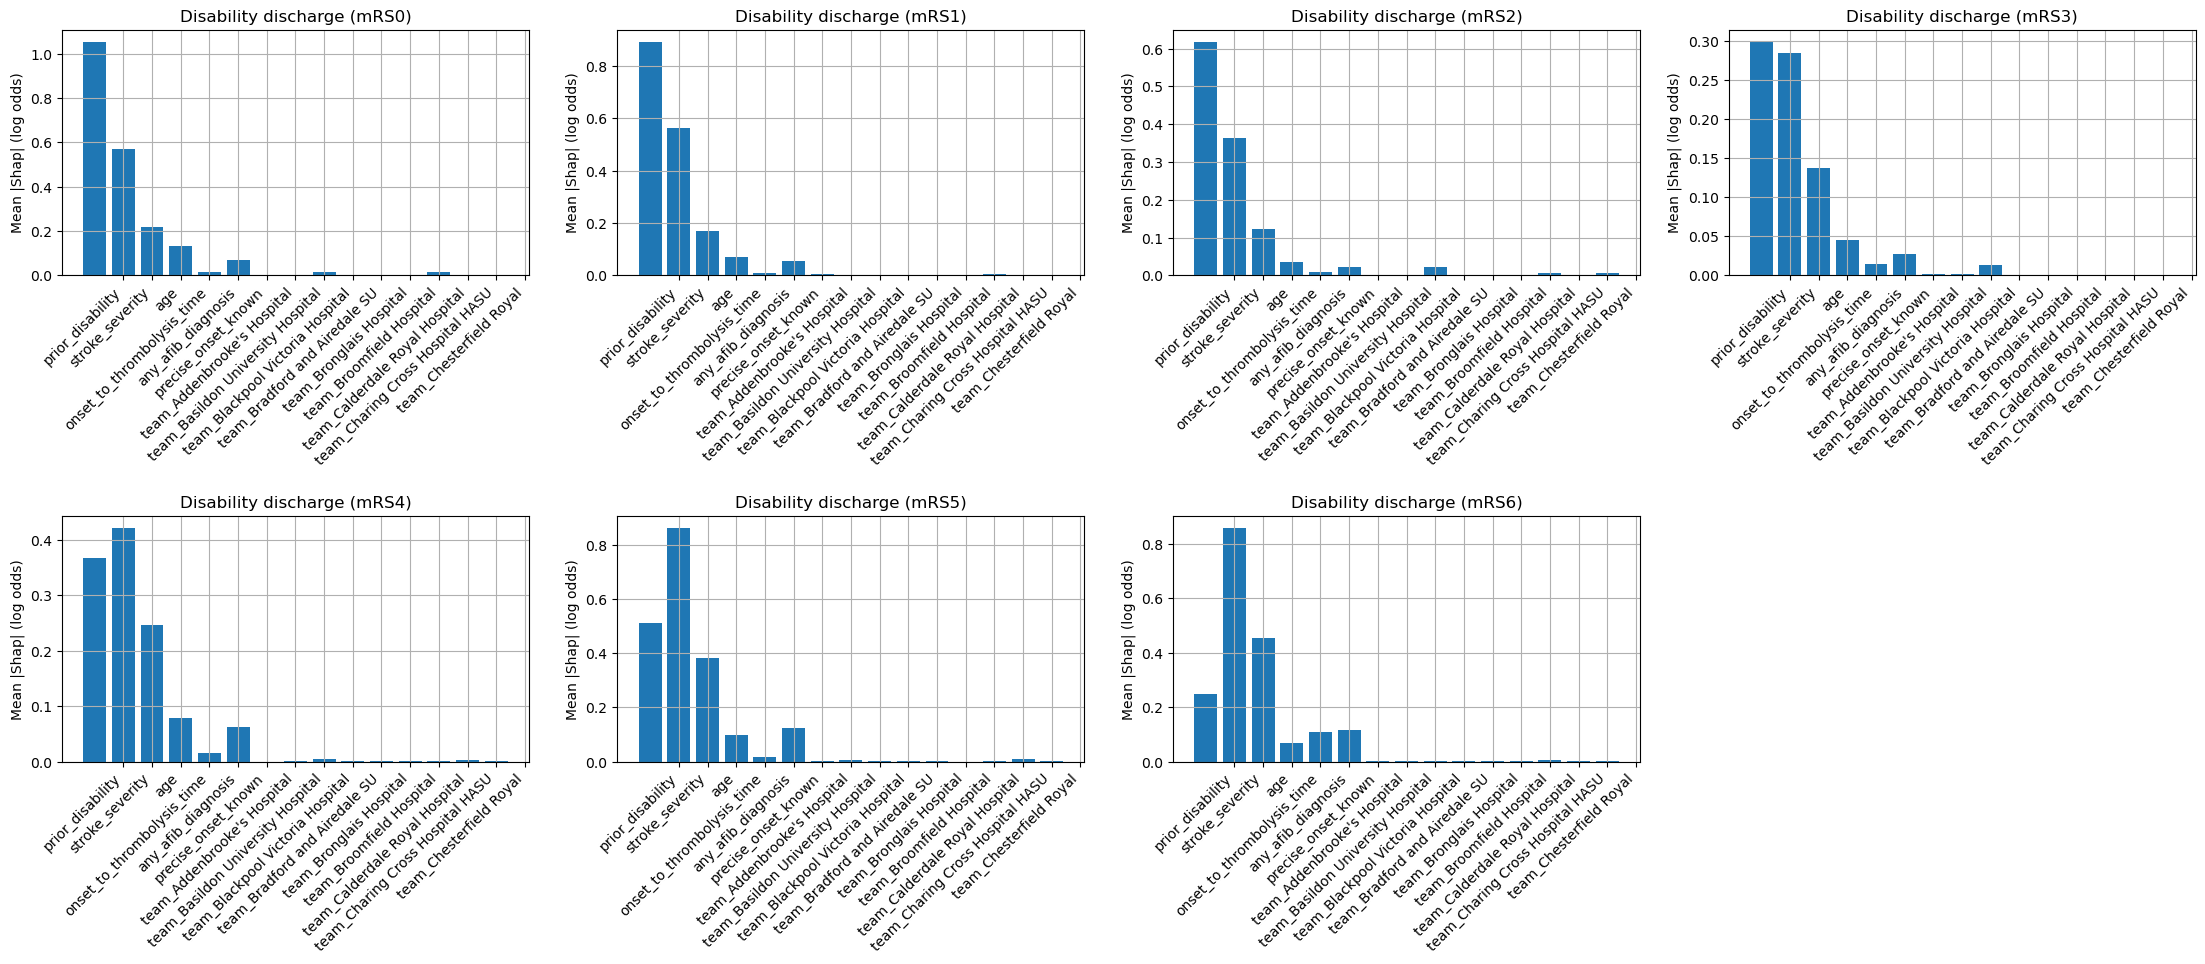

In [50]:
n_features_show = 15
features_show = (list(df_feature_importance.head(n_features_show).index))

width = 15 * (n_features_show/10)

fig = plt.figure(figsize=(width, 10))

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_mean_abs_shap = dict_mean_abs_shap[f'class{c}']
    ax1 = fig.add_subplot(2,4,c+1)
    ax1.bar(features_show, df_mean_abs_shap.iloc[:n_features_show].T)
    ax1.set_ylim(0)
    ax1.set_title(f'Disability discharge (mRS{c})')
    labels = df_mean_abs_shap.index[:n_features_show]
    ax1.set_xticks(np.arange(1, len(labels) + 1))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.grid(which='both')
    ax1.set_ylabel('Mean |Shap| (log odds)')

plt.subplots_adjust(bottom=0.25, wspace=0.05)
    
plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + '_shap_violin.jpg'))

plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

Surprised that the one hot encoded stroke team features are not dominating the ranked list (as in the feature importance)

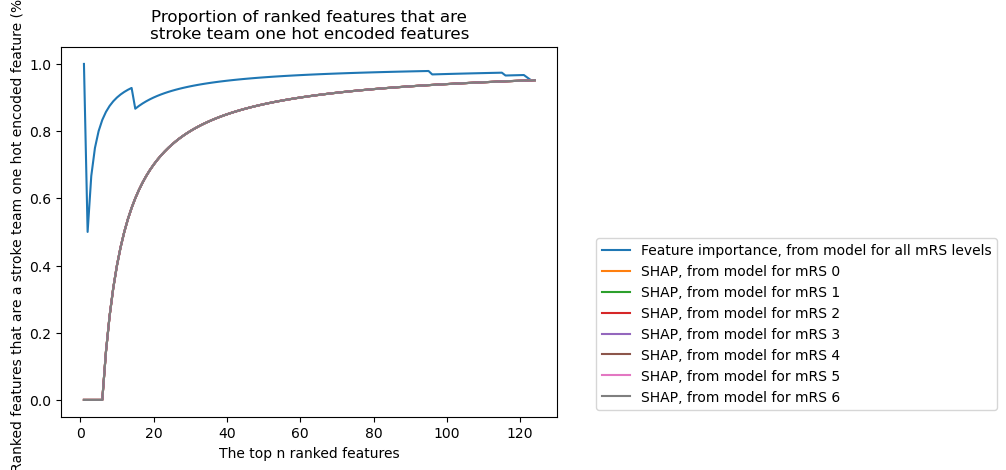

In [51]:
plt.plot(list(range(1, (n_features + 1),1)), list_pc_team_feature, 
         label="Feature importance, from model for all mRS levels")

for c in range(n_classes):

    # Data for the violin plot (for this class)
    df_mean_abs_shap = dict_mean_abs_shap[f'class{c}']

    # Create a mask for feature names that don't contain string "team"
    mask_exclude_team_features_shap = (
                ['team' not in i for i in list(df_mean_abs_shap.index.values)])
    mask_team_features_shap = (
                ['team' in i for i in list(df_mean_abs_shap.index.values)])

    list_pc_team_feature_shap = (
        [sum(mask_team_features_shap[:i+1])/(i+1) for i in range(n_features)])

    plt.plot(list(range(1, (n_features + 1),1)), 
             list_pc_team_feature_shap, label=f"SHAP, from model for mRS {c}")
#plt.xlim((0,10))
plt.title('Proportion of ranked features that are\nstroke team one hot encoded features')
plt.xlabel('The top n ranked features')
plt.ylabel('Ranked features that are a stroke team one hot encoded feature (%)')
plt.legend(loc="lower right", bbox_to_anchor=(1.9, 0))
filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_percent_team_ohe_features_ranked_importance.jpg'))
plt.savefig(filename, dpi=300)

## Section 1.3: Compare top 10 SHAP and feature importance values

Compare the features (and their values) that make the top 10 when selected by either SHAP values, or feature importance values.

In [61]:
df_compare_shap_importance = pd.DataFrame()
df_compare_shap_importance['Importance (feature name)'] = \
                            df_feature_importance.index
df_compare_shap_importance['Importance (median value)'] = \
                            df_feature_importance.values

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_compare_shap_importance[f'SHAP (feature name) [mRS{c}]'] = (
                            dict_mean_abs_shap[f'class{c}'].index)
    df_compare_shap_importance[f'SHAP (median value) [mRS{c}]'] = (
                            dict_mean_abs_shap[f'class{c}'].values)
               
df_compare_shap_importance.head(10)

,Importance (feature name),Importance (median value),SHAP (feature name) [mRS0],SHAP (median value) [mRS0],SHAP (feature name) [mRS1],SHAP (median value) [mRS1],SHAP (feature name) [mRS2],SHAP (median value) [mRS2],SHAP (feature name) [mRS3],SHAP (median value) [mRS3],SHAP (feature name) [mRS4],SHAP (median value) [mRS4],SHAP (feature name) [mRS5],SHAP (median value) [mRS5],SHAP (feature name) [mRS6],SHAP (median value) [mRS6]
0,team_Royal Stoke University Hospital,0.047376,prior_disability,1.054294,prior_disability,0.892900,prior_disability,0.618555,prior_disability,0.298956,prior_disability,0.367335,prior_disability,0.511440,prior_disability,0.247602
1,prior_disability,0.033415,stroke_severity,0.570699,stroke_severity,0.562539,stroke_severity,0.363743,stroke_severity,0.284242,stroke_severity,0.421994,stroke_severity,0.862382,stroke_severity,0.859565
2,team_Salford Royal Hospital,0.029576,age,0.218952,age,0.169728,age,0.122397,age,0.137607,age,0.246964,age,0.382515,age,0.453346
3,team_University Hospital of North Durham,0.025092,onset_to_thrombolysis_time,0.132096,onset_to_thrombolysis_time,0.068791,onset_to_thrombolysis_time,0.034600,onset_to_thrombolysis_time,0.044957,onset_to_thrombolysis_time,0.078292,onset_to_thrombolysis_time,0.099045,onset_to_thrombolysis_time,0.068064
4,team_Leicester Royal Infirmary,0.019328,any_afib_diagnosis,0.015472,any_afib_diagnosis,0.008578,any_afib_diagnosis,0.008492,any_afib_diagnosis,0.014026,any_afib_diagnosis,0.015975,any_afib_diagnosis,0.017514,any_afib_diagnosis,0.109416
5,team_Sandwell District Hospital,0.018564,precise_onset_known,0.068582,precise_onset_known,0.056611,precise_onset_known,0.022274,precise_onset_known,0.027980,precise_onset_known,0.062133,precise_onset_known,0.125011,precise_onset_known,0.115371
6,team_Royal Hallamshire Hospital,0.017819,team_Addenbrooke's Hospital,0.000555,team_Addenbrooke's Hospital,0.006286,team_Addenbrooke's Hospital,0.000350,team_Addenbrooke's Hospital,0.002014,team_Addenbrooke's Hospital,0.000000,team_Addenbrooke's Hospital,0.001616,team_Addenbrooke's Hospital,0.001821
7,team_Ysbyty Gwynedd,0.017046,team_Basildon University Hospital,0.001175,team_Basildon University Hospital,0.000421,team_Basildon University Hospital,0.001421,team_Basildon University Hospital,0.002026,team_Basildon University Hospital,0.000966,team_Basildon University Hospital,0.004273,team_Basildon University Hospital,0.003217
8,team_Pinderfields Hospital,0.016385,team_Blackpool Victoria Hospital,0.015973,team_Blackpool Victoria Hospital,0.001185,team_Blackpool Victoria Hospital,0.021132,team_Blackpool Victoria Hospital,0.013016,team_Blackpool Victoria Hospital,0.004521,team_Blackpool Victoria Hospital,0.002847,team_Blackpool Victoria Hospital,0.002647
9,team_Blackpool Victoria Hospital,0.015405,team_Bradford and Airedale SU,0.001279,team_Bradford and Airedale SU,0.000000,team_Bradford and Airedale SU,0.000181,team_Bradford and Airedale SU,0.000747,team_Bradford and Airedale SU,0.000583,team_Bradford and Airedale SU,0.000647,team_Bradford and Airedale SU,0.000693


Plot all of the features, showing feature importance vs SHAP values.

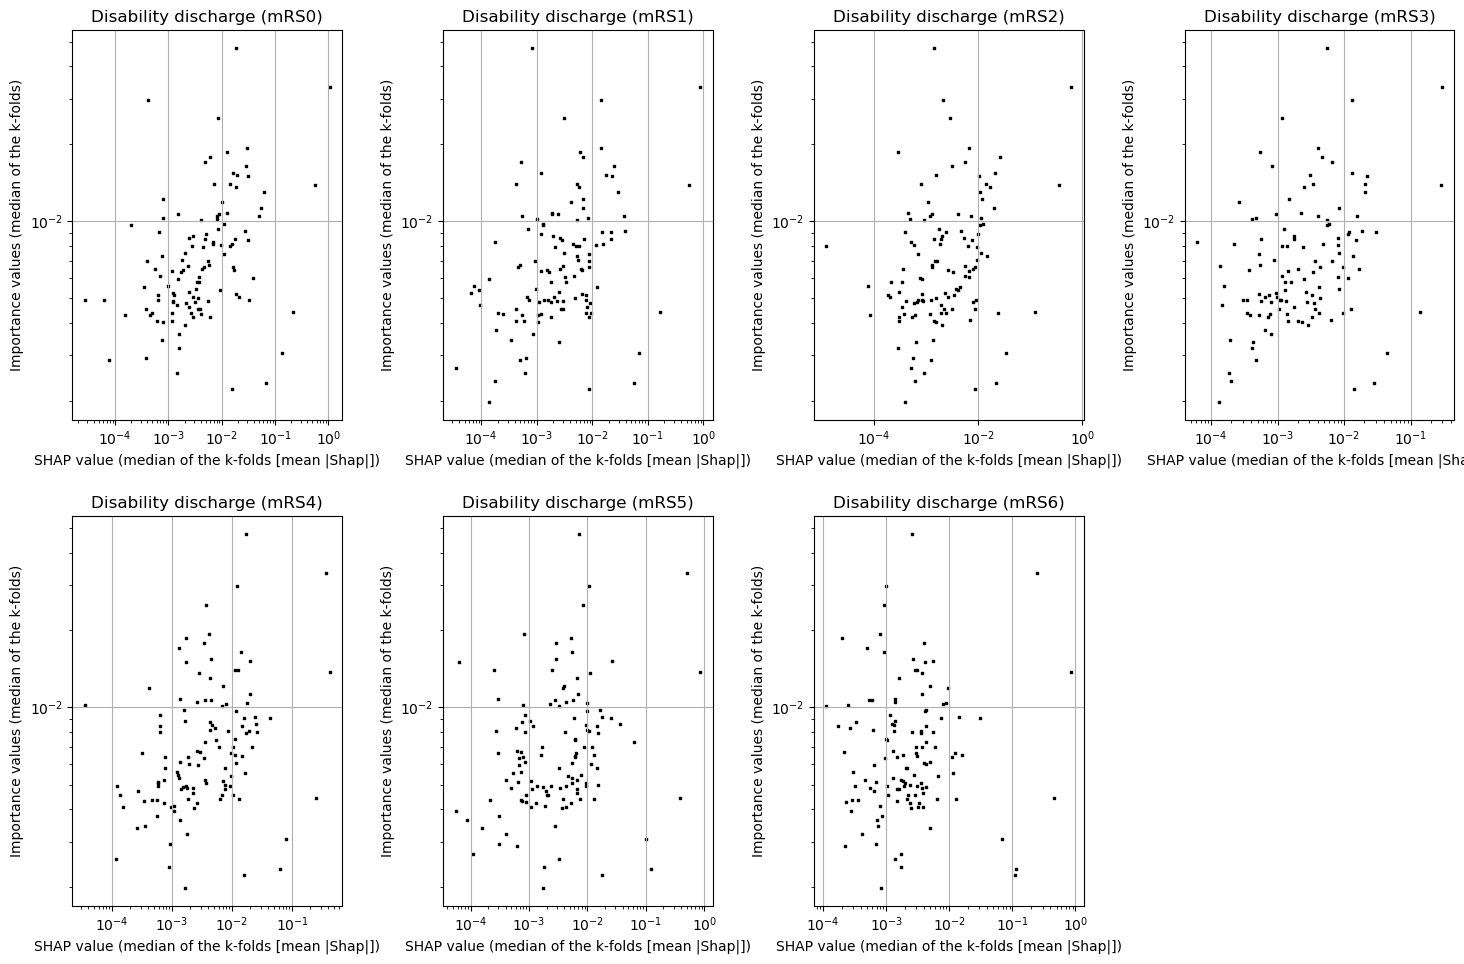

In [68]:
fig = plt.figure(figsize=(15, 10))

for c in range(n_classes):
    # Data for the violin plot (for this class)
    df_mean_abs_shap = dict_mean_abs_shap[f'class{c}']
    

    df_shap_importance = pd.DataFrame()
    df_shap_importance['Shap'] =  df_mean_abs_shap
    df_shap_importance = df_shap_importance.merge(
                        df_feature_importance, 
                        left_index=True, right_index=True)
    
    # Give the column from the series the column name "Importance"
    df_shap_importance.rename(columns={'0': 'Importance'}, 
                              inplace=True)
    df_shap_importance.sort_values('Shap', inplace=True, ascending=False)

    ax1 = fig.add_subplot(2,4,c+1)
    ax1.scatter(df_shap_importance['Shap'], df_shap_importance['Importance'], 
                c='k', marker='s', s=1)
    ax1.set_title(f'Disability discharge (mRS{c})')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('SHAP value (median of the k-folds [mean |Shap|])')
    ax1.set_ylabel('Importance values (median of the k-folds)')
    ax1.grid()

plt.subplots_adjust(bottom=0.25, wspace=0.05)

plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_shap_importance_correlation.jpg'))

plt.savefig(filename, dpi=300)
plt.show()


Show summary SHAP plot for the first kfold.

Shows the mean absolute SHAP for each feature for each class output.

Need to reformat the SHAP values (as they contain multiclass output) into a list, with the SHAP value array for each class as a separate element in the list. Otherwise, if we pass the 3D array (instance, feature, class) to shap.summary_plot, the function will assume that the 3D array contains shap interaction values. For our case the 3D array is of size (33670, 177, 7). It will create a grid of plots of each pair-wise combination of the first 7 features, and treat the values as SHAP interactions.

We instead want to have a list of length 7 (the last array dimension), an array in the list per class.
```
shap.summary_plot(shap_values_kfold[k], X_test.values, plot_type="bar", 
                class_names= class_names, feature_names = X_test.columns, 
                show=False, plot_size=(6,6), title=f"k-fold {k+1}")
```

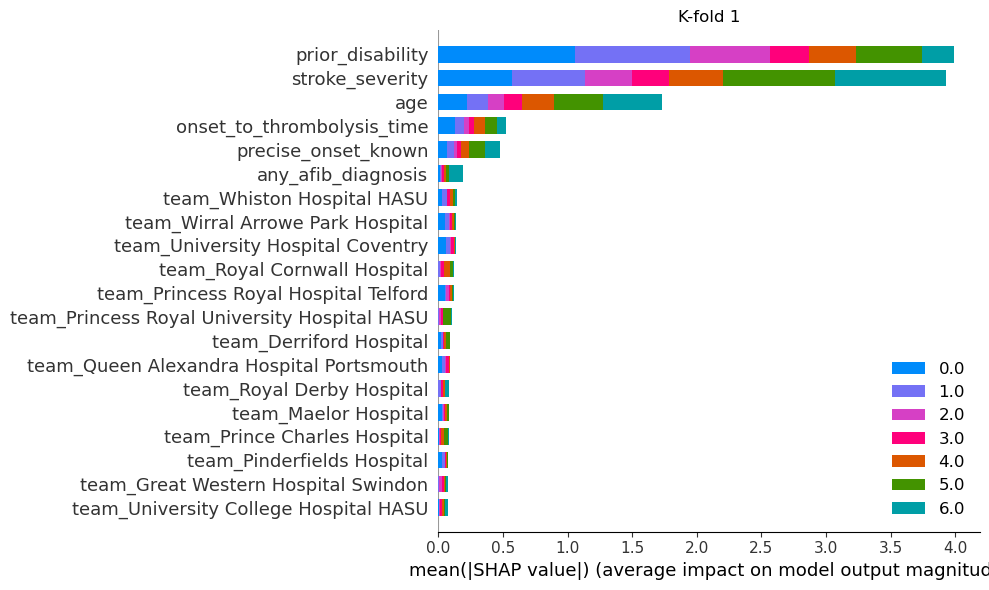

In [75]:
# Initialise empty list
shap_values_list = []
# Putting the SHAP values in the required format
for c in range(n_classes):
    shap_values_list.append(shap_values[:,:,c])

# Plot a SHAP summary plot, one for each k-fold
shap.summary_plot(shap_values_list, X_test.values, plot_type="bar", 
                    class_names=model.classes_, 
                    feature_names = X_test.columns, class_inds="original",
                    show=False, plot_size=(10,6))
plt.title(f"K-fold {k+1}")
plt.tight_layout()
plt.show()

You can also see the summary_plot of a specific class.

Loop through the classes.

```shap_values[instance, feature, class]```

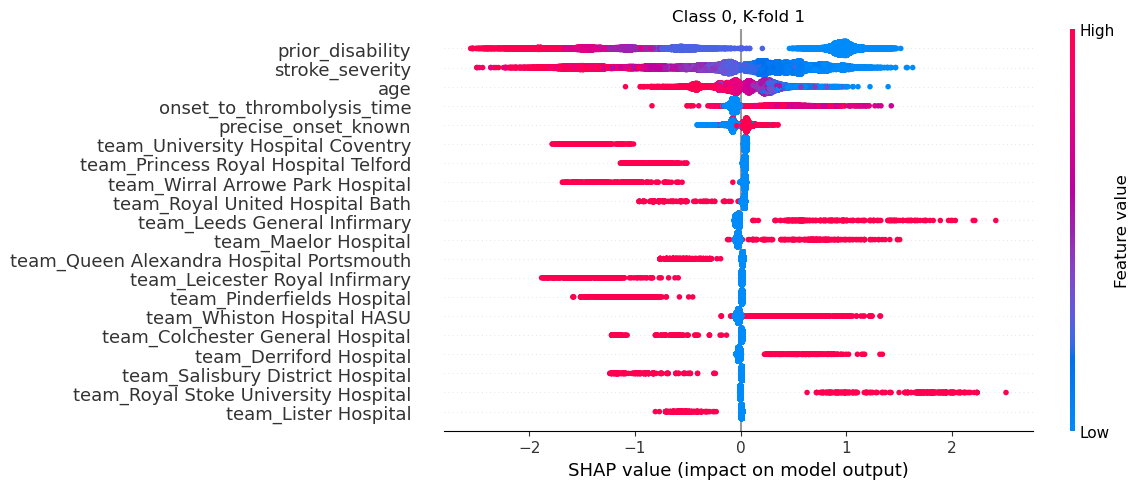

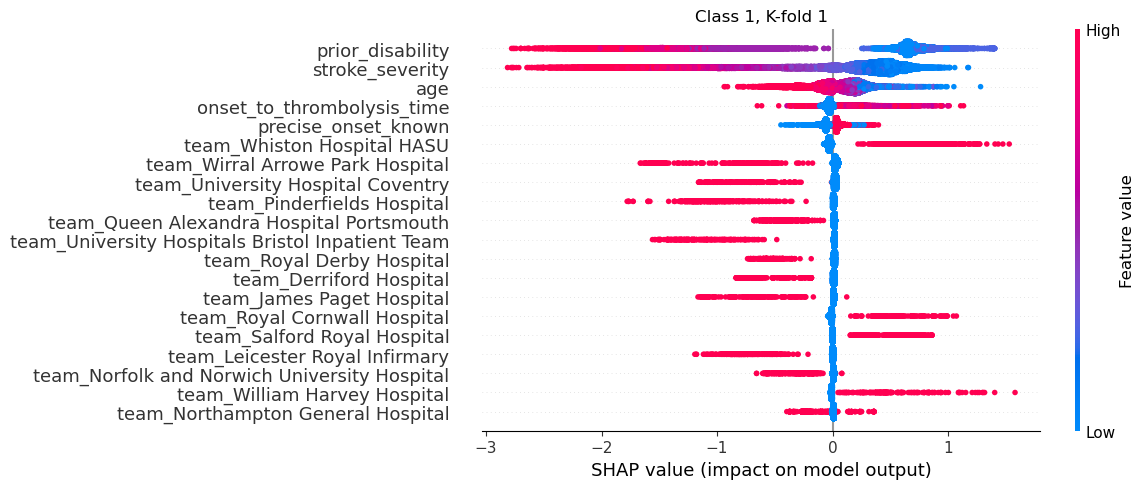

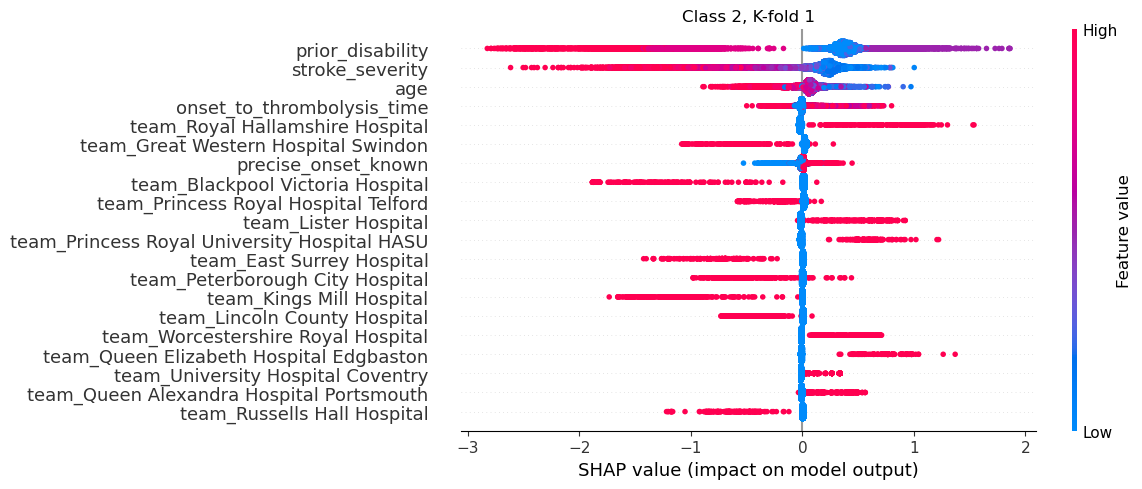

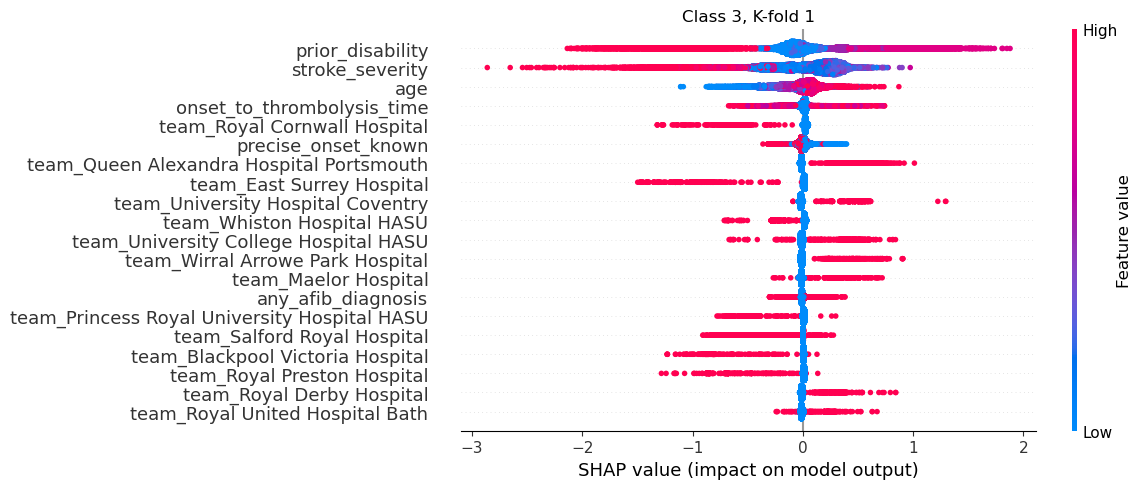

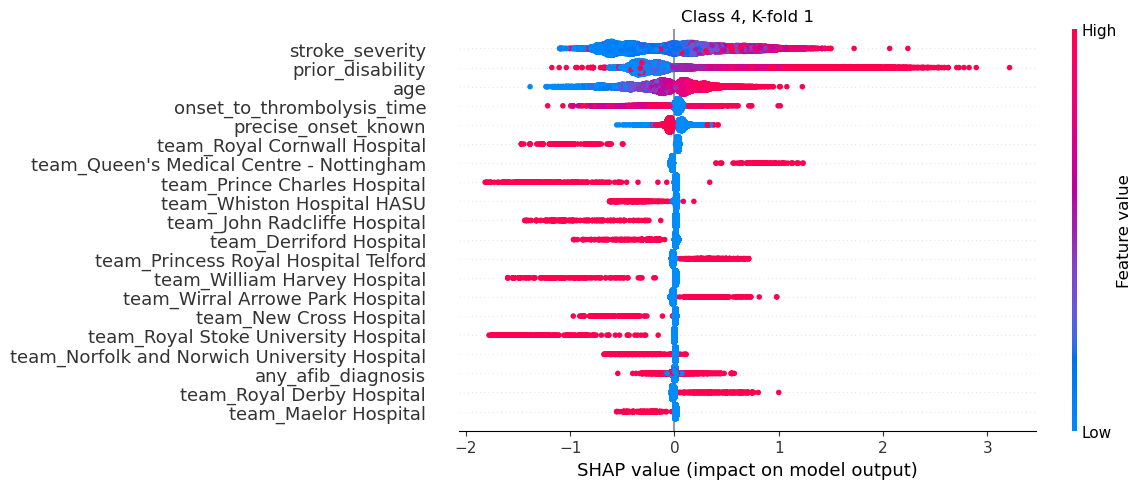

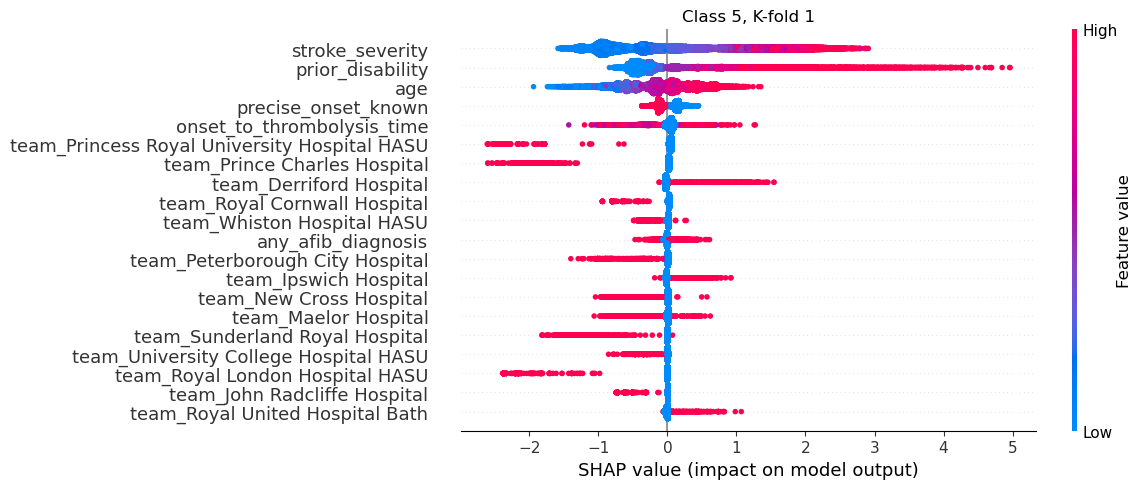

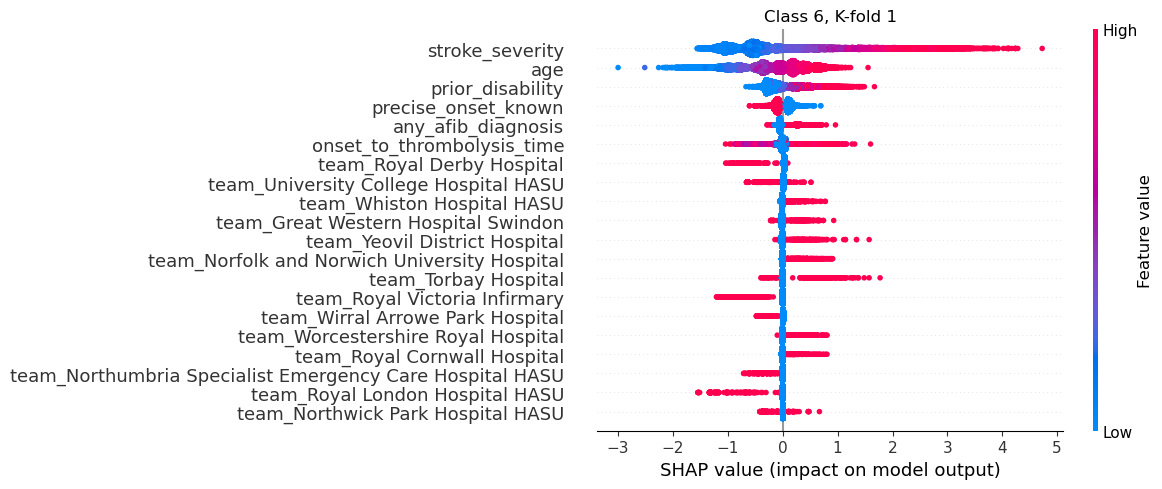

In [76]:
for c in range(len(class_names)):

    shap.summary_plot(shap_values[:,:,c], X_test.values, 
                    feature_names=X_test.columns, show=False, 
                    plot_size=(12,5))

    plt.title(f"Class {c}, K-fold {k+1}")
    plt.tight_layout()
    plt.show()

Duration to run notebook

In [ ]:
str(datetime.timedelta(seconds=(time.time()-start_time)))